# 05 - ERT Fundamentals

Electrical Resistivity Tomography (ERT) is HIRT's second sensing modality.
This notebook covers the analytical physics:

1. **Geometric factors** for standard and cross-hole electrode arrays
2. **Apparent resistivity** for homogeneous and layered half-spaces
3. **HIRT electrode configuration** — 2 boreholes x 8 ring electrodes
4. **ERT forward modeling** — Wenner pseudosection and cross-hole

**Scenario:** `swamp-crash-site.json`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from geosim.resistivity.geometric import (
    geometric_factor, geometric_factor_wenner,
    geometric_factor_schlumberger, geometric_factor_dipole_dipole,
    geometric_factor_hirt_crosshole,
)
from geosim.resistivity.ert import (
    apparent_resistivity_halfspace, apparent_resistivity_layered,
    ert_forward,
)
from geosim.resistivity.electrodes import (
    Electrode, ElectrodeArray, hirt_default_electrodes,
)
from geosim.scenarios.loader import load_scenario

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Apparent Resistivity: Homogeneous Half-Space

For a uniform half-space with resistivity $\rho$, the apparent resistivity
$\rho_a = K \cdot V/I$ should equal the true resistivity regardless of
electrode configuration. Let's verify this basic identity.

In [2]:
# Verify rho_a = rho for homogeneous half-space with different arrays
true_rho = 100.0  # 100 Ohm-m

configs = [
    ('Wenner a=1m', [0, 0], [3, 0], [1, 0], [2, 0]),
    ('Wenner a=2m', [0, 0], [6, 0], [2, 0], [4, 0]),
    ('Schlumberger', [0, 0], [10, 0], [4, 0], [6, 0]),
    ('Dipole-dipole', [0, 0], [1, 0], [3, 0], [4, 0]),
    ('Cross-hole', [0, 0], [0, 1], [5, 0], [5, 1]),
]

print(f'{"Array":<20} {"K (m)":>10} {"rho_a (Ohm-m)":>15} {"Error":>12}')
print('-' * 60)

for name, c1, c2, p1, p2 in configs:
    K = geometric_factor(np.array(c1), np.array(c2), np.array(p1), np.array(p2))
    rho_a = apparent_resistivity_halfspace(
        true_rho, np.array(c1), np.array(c2), np.array(p1), np.array(p2)
    )
    err = abs(rho_a - true_rho) / true_rho
    print(f'{name:<20} {K:>10.4f} {rho_a:>15.6f} {err:>12.2e}')

Array                     K (m)   rho_a (Ohm-m)        Error
------------------------------------------------------------
Wenner a=1m              6.2832      100.000000     0.00e+00
Wenner a=2m             12.5664      100.000000     0.00e+00
Schlumberger            37.6991      100.000000     1.42e-16
Dipole-dipole          -75.3982      100.000000     0.00e+00
Cross-hole             808.8831      100.000000     0.00e+00


## 2. Geometric Factor Comparison

The geometric factor K relates measured resistance to apparent resistivity:
$\rho_a = K \cdot (V/I)$.

Each array type has a different K formula:
- **Wenner:** $K = 2\pi a$
- **Schlumberger:** $K = \pi n(n+1)a$
- **Dipole-dipole:** $K = \pi n(n+1)(n+2)a$

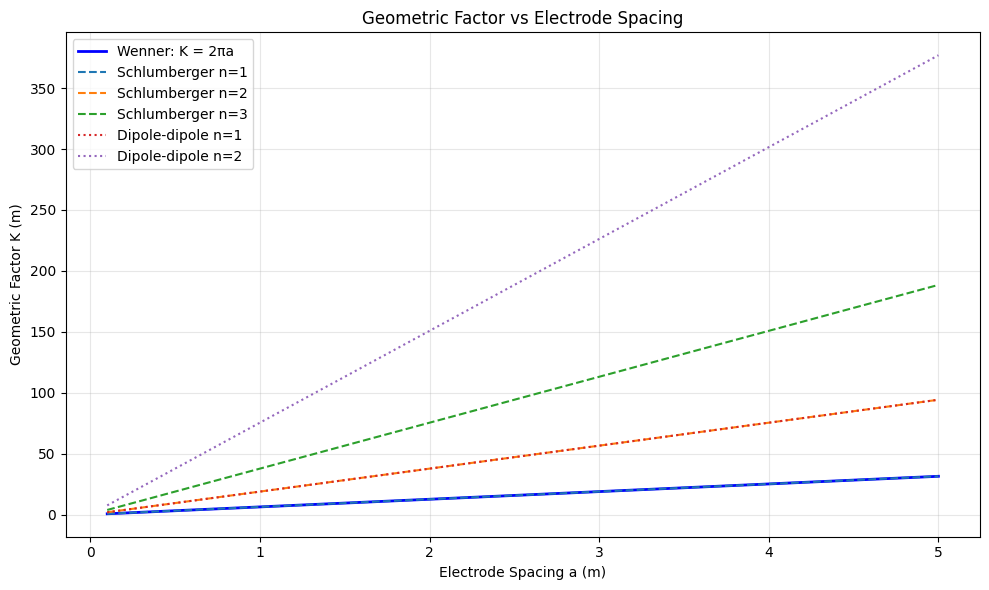

In [3]:
# K vs spacing for each array type
spacings = np.linspace(0.1, 5.0, 100)

fig, ax = plt.subplots(figsize=(10, 6))

K_wenner = [geometric_factor_wenner(a) for a in spacings]
ax.plot(spacings, K_wenner, 'b-', lw=2, label='Wenner: K = 2\u03c0a')

for n in [1, 2, 3]:
    K_schlum = [geometric_factor_schlumberger(a, n) for a in spacings]
    ax.plot(spacings, K_schlum, '--', lw=1.5, label=f'Schlumberger n={n}')

for n in [1, 2]:
    K_dd = [geometric_factor_dipole_dipole(a, n) for a in spacings]
    ax.plot(spacings, K_dd, ':', lw=1.5, label=f'Dipole-dipole n={n}')

ax.set_xlabel('Electrode Spacing a (m)')
ax.set_ylabel('Geometric Factor K (m)')
ax.set_title('Geometric Factor vs Electrode Spacing')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

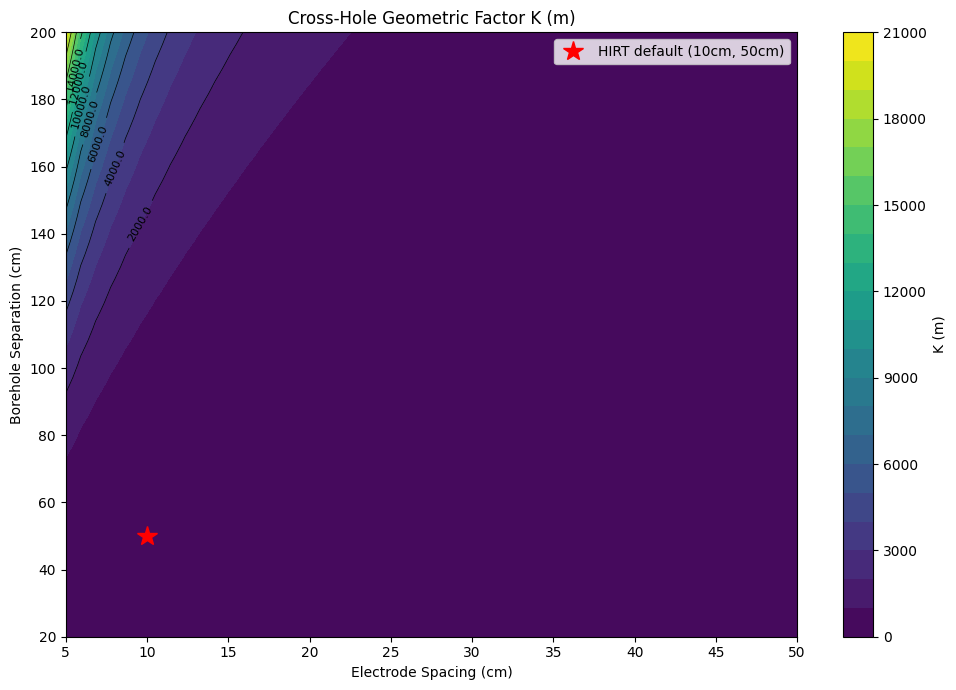

In [4]:
# HIRT cross-hole K: contour plot of K vs electrode and borehole spacing
e_spacings = np.linspace(0.05, 0.5, 50)   # electrode spacing in borehole
b_spacings = np.linspace(0.2, 2.0, 50)    # borehole separation
E, B = np.meshgrid(e_spacings, b_spacings)

K_crosshole = np.zeros_like(E)
for i in range(len(b_spacings)):
    for j in range(len(e_spacings)):
        K_crosshole[i, j] = geometric_factor_hirt_crosshole(e_spacings[j], b_spacings[i])

fig, ax = plt.subplots(figsize=(10, 7))
cs = ax.contourf(E * 100, B * 100, K_crosshole, levels=20, cmap='viridis')
ct = ax.contour(E * 100, B * 100, K_crosshole, levels=10, colors='k', linewidths=0.5)
ax.clabel(ct, fmt='%.1f', fontsize=8)

# Mark HIRT default configuration
ax.plot(10, 50, 'r*', markersize=15, label='HIRT default (10cm, 50cm)')

ax.set_xlabel('Electrode Spacing (cm)')
ax.set_ylabel('Borehole Separation (cm)')
ax.set_title('Cross-Hole Geometric Factor K (m)')
plt.colorbar(cs, ax=ax, label='K (m)')
ax.legend()

plt.tight_layout()

## 3. HIRT Electrode Configuration

The HIRT uses 2 boreholes, each with 8 ring electrodes at regular intervals.
The `hirt_default_electrodes()` function creates this standard layout.

Array: hirt_crosshole
Total electrodes: 16
Borehole 0: 8 electrodes
Borehole 1: 8 electrodes


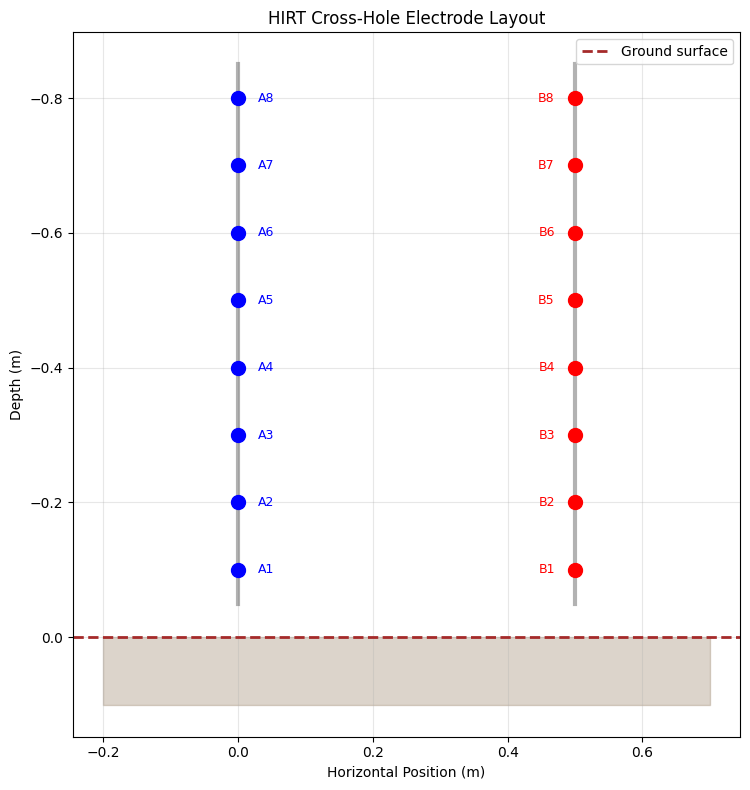

In [5]:
array = hirt_default_electrodes()

print(f'Array: {array.name}')
print(f'Total electrodes: {array.n_electrodes}')
print(f'Borehole 0: {len(array.borehole_electrodes(0))} electrodes')
print(f'Borehole 1: {len(array.borehole_electrodes(1))} electrodes')

# Cross-section diagram
fig, ax = plt.subplots(figsize=(8, 8))

for bh in range(2):
    elecs = array.borehole_electrodes(bh)
    x_pos = elecs[0].position[0]

    # Draw borehole
    z_min = min(e.position[2] for e in elecs) - 0.05
    z_max = max(e.position[2] for e in elecs) + 0.05
    ax.plot([x_pos, x_pos], [z_min, z_max], 'k-', lw=3, alpha=0.3)

    for e in elecs:
        color = 'blue' if bh == 0 else 'red'
        ax.plot(e.position[0], e.position[2], 'o', color=color, markersize=10)
        ax.text(e.position[0] + 0.03 * (1 - 2*bh), e.position[2],
                e.label, fontsize=9, ha='left' if bh == 0 else 'right',
                va='center', color=color)

# Ground surface
ax.axhline(0, color='brown', lw=2, ls='--', label='Ground surface')
ax.fill_between([-0.2, 0.7], 0, 0.1, color='#8B7355', alpha=0.3)

ax.set_xlabel('Horizontal Position (m)')
ax.set_ylabel('Depth (m)')
ax.set_title('HIRT Cross-Hole Electrode Layout')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()

## 4. Layered-Earth Sounding Curves

For a 1D layered earth, the apparent resistivity varies with electrode spacing.
A sounding curve plots $\rho_a$ vs spacing — the shape reveals the layer structure.

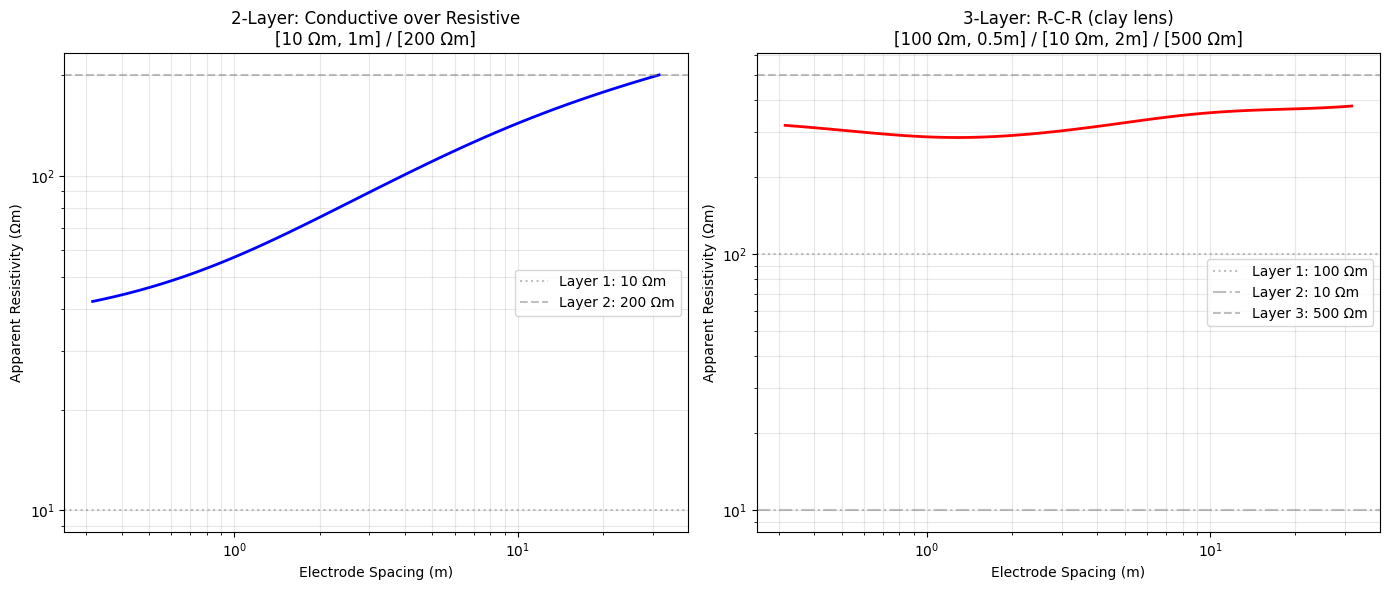

In [6]:
# 2-layer and 3-layer models
spacings = np.logspace(-0.5, 1.5, 50)  # 0.3m to 30m

# 2-layer: conductive over resistive
rho_a_2L = [apparent_resistivity_layered([1.0], [10.0, 200.0], a) for a in spacings]

# 3-layer: resistive - conductive - resistive (like a clay lens)
rho_a_3L = [apparent_resistivity_layered([0.5, 2.0], [100.0, 10.0, 500.0], a) for a in spacings]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.loglog(spacings, rho_a_2L, 'b-', lw=2)
ax1.axhline(10, color='gray', ls=':', alpha=0.5, label='Layer 1: 10 \u03a9m')
ax1.axhline(200, color='gray', ls='--', alpha=0.5, label='Layer 2: 200 \u03a9m')
ax1.set_xlabel('Electrode Spacing (m)')
ax1.set_ylabel('Apparent Resistivity (\u03a9m)')
ax1.set_title('2-Layer: Conductive over Resistive\n[10 \u03a9m, 1m] / [200 \u03a9m]')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

ax2.loglog(spacings, rho_a_3L, 'r-', lw=2)
ax2.axhline(100, color='gray', ls=':', alpha=0.5, label='Layer 1: 100 \u03a9m')
ax2.axhline(10, color='gray', ls='-.', alpha=0.5, label='Layer 2: 10 \u03a9m')
ax2.axhline(500, color='gray', ls='--', alpha=0.5, label='Layer 3: 500 \u03a9m')
ax2.set_xlabel('Electrode Spacing (m)')
ax2.set_ylabel('Apparent Resistivity (\u03a9m)')
ax2.set_title('3-Layer: R-C-R (clay lens)\n[100 \u03a9m, 0.5m] / [10 \u03a9m, 2m] / [500 \u03a9m]')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

Swamp resistivity model:
  Layer 1: Peat/organic topsoil           rho=6.7 Ohm-m  thickness=0.5
  Layer 2: Saturated clay                 rho=3.3 Ohm-m  thickness=2.5
  Layer 3: Waterlogged sand/gravel        rho=12.5 Ohm-m  thickness=halfspace


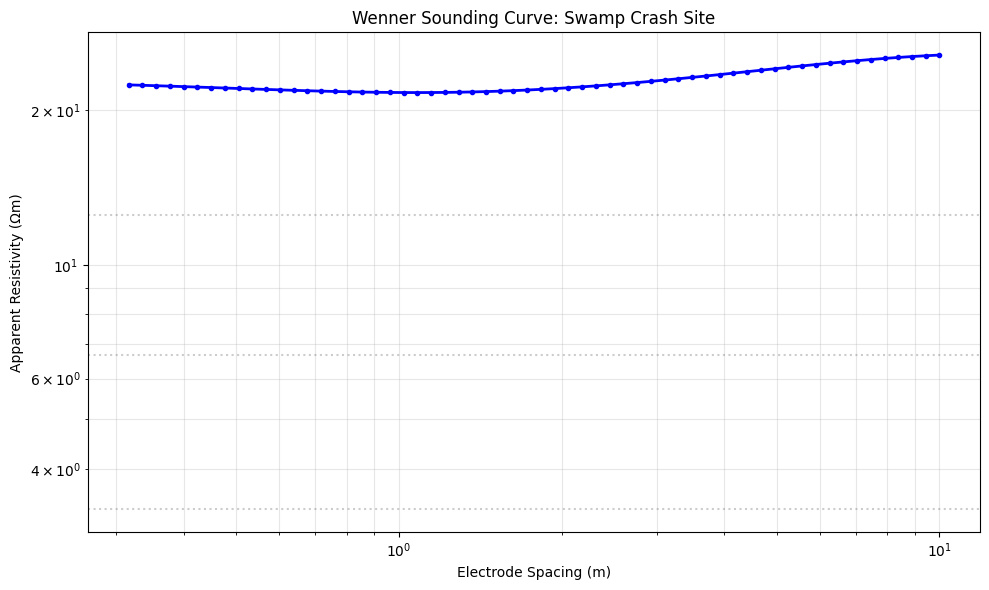

In [7]:
# Swamp scenario sounding curve
scenario = load_scenario(Path('..') / 'scenarios' / 'swamp-crash-site.json')
res_model = scenario.resistivity_model

print('Swamp resistivity model:')
for i, rho in enumerate(res_model['resistivities']):
    h = res_model['thicknesses'][i] if i < len(res_model['thicknesses']) else 'halfspace'
    layer_name = scenario.terrain.layers[i].name if i < len(scenario.terrain.layers) else ''
    print(f'  Layer {i+1}: {layer_name:<30} rho={rho:.1f} Ohm-m  thickness={h}')

spacings = np.logspace(-0.5, 1.0, 60)
rho_a_swamp = [apparent_resistivity_layered(
    res_model['thicknesses'], res_model['resistivities'], a
) for a in spacings]

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(spacings, rho_a_swamp, 'b-o', lw=2, markersize=3)

for rho in res_model['resistivities']:
    ax.axhline(rho, color='gray', ls=':', alpha=0.4)

ax.set_xlabel('Electrode Spacing (m)')
ax.set_ylabel('Apparent Resistivity (\u03a9m)')
ax.set_title('Wenner Sounding Curve: Swamp Crash Site')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()

## 5. ERT Forward Model: Wenner Pseudosection

A pseudosection arranges measurements by their midpoint and pseudo-depth
(proportional to electrode spacing), creating a 2D image of subsurface
resistivity variation.

Electrodes: 16
Measurements: 34


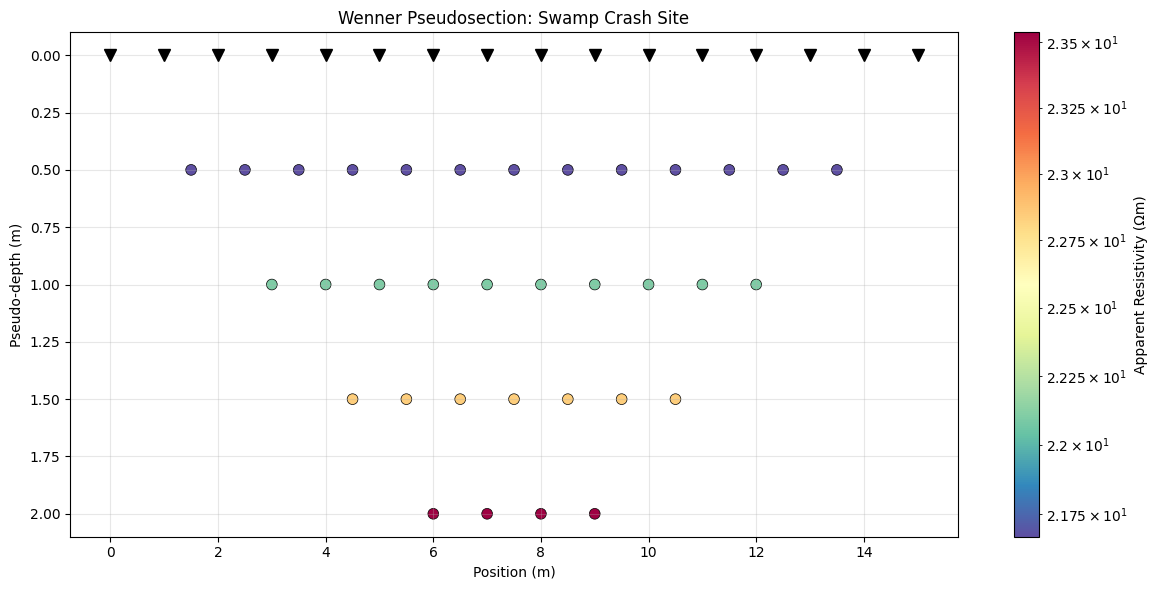

In [8]:
# Build a 16-electrode Wenner survey
n_elec = 16
elec_spacing = 1.0  # 1m spacing
positions = np.column_stack([
    np.arange(n_elec) * elec_spacing,
    np.zeros(n_elec),
])

# Generate Wenner measurement configurations
measurements = []
pseudo_x = []
pseudo_z = []
for a_mult in range(1, n_elec // 3):
    a = a_mult * elec_spacing
    for i in range(n_elec - 3 * a_mult):
        c1 = i
        p1 = i + a_mult
        p2 = i + 2 * a_mult
        c2 = i + 3 * a_mult
        measurements.append((c1, c2, p1, p2))
        pseudo_x.append(positions[i, 0] + 1.5 * a)
        pseudo_z.append(a / 2)  # pseudo-depth

print(f'Electrodes: {n_elec}')
print(f'Measurements: {len(measurements)}')

# Run forward model with swamp layered model
result = ert_forward(
    positions, measurements,
    resistivities=res_model['resistivities'],
    thicknesses=res_model['thicknesses'],
    backend='analytical',
)

# Plot pseudosection
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    pseudo_x, pseudo_z,
    c=result['apparent_resistivity'],
    cmap='Spectral_r', s=60, edgecolors='k', linewidth=0.5,
    norm=plt.matplotlib.colors.LogNorm(),
)
plt.colorbar(sc, ax=ax, label='Apparent Resistivity (\u03a9m)')

# Electrode positions
ax.plot(positions[:, 0], np.zeros(n_elec), 'kv', markersize=8)

ax.set_xlabel('Position (m)')
ax.set_ylabel('Pseudo-depth (m)')
ax.set_title('Wenner Pseudosection: Swamp Crash Site')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 6. Cross-Hole ERT from HIRT Configuration

The HIRT cross-hole configuration uses adjacent electrode pairs in each borehole.
Let's compute the apparent resistivity distribution for the HIRT default geometry.

Total ERT measurements: 98
Example: C1=A1, C2=A2, P1=B1, P2=B2

Apparent resistivity range: 22.8 to 22.9 Ohm-m


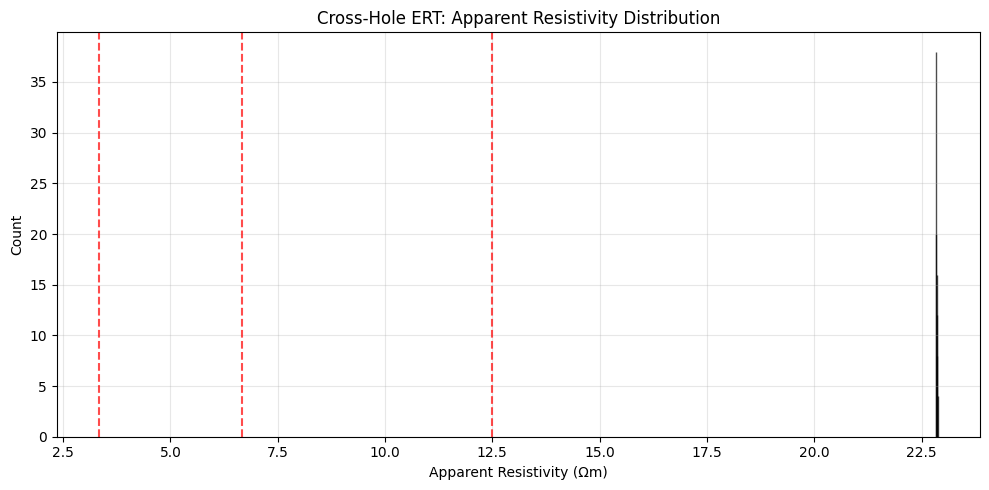

In [9]:
from geosim.sensors.hirt import generate_ert_measurements, simulate_ert, HIRTSurveyConfig

# Use scenario's probe configuration
probes = scenario.hirt_config.probes
config = HIRTSurveyConfig()

ert_meas = generate_ert_measurements(probes, config.electrode_array)
print(f'Total ERT measurements: {len(ert_meas)}')
print(f'Example: C1={ert_meas[0].c1_label}, C2={ert_meas[0].c2_label}, '
      f'P1={ert_meas[0].p1_label}, P2={ert_meas[0].p2_label}')

# Simulate
rng = np.random.default_rng(42)
ert_data = simulate_ert(ert_meas, scenario.resistivity_model, config, rng, add_noise=False)

rho_a = np.array(ert_data['apparent_resistivity'])
print(f'\nApparent resistivity range: {rho_a.min():.1f} to {rho_a.max():.1f} Ohm-m')

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(rho_a, bins=30, color='steelblue', edgecolor='black', alpha=0.7)

for rho in res_model['resistivities']:
    ax.axvline(rho, color='red', ls='--', alpha=0.7)

ax.set_xlabel('Apparent Resistivity (\u03a9m)')
ax.set_ylabel('Count')
ax.set_title('Cross-Hole ERT: Apparent Resistivity Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()

## Key Takeaways

1. **Apparent resistivity = true resistivity** for a homogeneous half-space, regardless of array type
2. **Geometric factor K** grows with electrode spacing — larger arrays measure deeper but need more signal
3. **Cross-hole K** depends on both electrode spacing and borehole separation
4. **Sounding curves** reveal layer structure: $\rho_a$ transitions between layer values with spacing
5. **The swamp model** shows low resistivities (3-12 \u03a9m) due to saturated clay — ideal for ERT imaging
6. **HIRT's 16 electrodes** (2 x 8) produce 98 independent measurements for tomographic imaging

Next: [06-hirt-borehole-survey.ipynb](06-hirt-borehole-survey.ipynb) — End-to-end HIRT survey simulation